# Download model variables

Download as raster layers covering your study area envelope, including:

- At least one **soil** variable from the [POLARIS dataset](http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/) (**find thresholds**)
    - [POLARIS: 30-meter probabilistic soil series map of contiguous US](https://pubs.usgs.gov/publication/70170912)
    - <https://scholars.duke.edu/publication/1381493>
    - <https://gee-community-catalog.org/projects/polaris/>
    - NW Chaney et al. (2019) POLARIS Soil Properties: 30-m Probabilistic Maps of Soil Properties Over the Contiguous United States. [DOI: 10.1029/2018WR022797](https://doi.org/10.1029/2018WR022797)
    - Elsa Culler EarthLab Videos
        - [Accessing and formatting URLS for POLARIS data](https://cuboulder.zoom.us/rec/share/imhCGJcrCgSoE1cJjg02r86GMNjiRz0jwVMJ5c0uWNwBCD5D_0kLSl3CaqLdDI2a.ucGta1EEAiirDUop)
        - [Looping through multiple tiles of POLARIS data](https://cuboulder.zoom.us/rec/share/3S7pGOSv7jztZTvg4RSXLj-GicnHwusIDIEDoETZbUN7ivkc6Ryi5GAJyX9Ly6h2.VXl6iFmLChjjUyOg)
- Elevation from the SRTM (available from the [earthaccess API](https://github.com/nsidc/earthaccess/))
- At least one **climate** variable from the [MACAv2 THREDDS data server](http://thredds.northwestknowledge.net:8080/thredds/reacch_climate_CMIP5_macav2_catalog2.html).
    - Pick 2 of these
    - [GeoNetwork](https://docs.geonetwork-opensource.org/4.2/):
[THREDDS Harvesting](https://docs.geonetwork-opensource.org/4.2/user-guide/harvesting/harvesting-thredds/)

## POLARIS Dataset

Considering `sand` percentage `mean`. POLARIS data are available at 6 depths, and Bluestem has roots down to 5 feet (150 cm), which is the lowest strata measured (100-200 cm). Data in the
[sand 100-200 cm directory](http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/sand/mean/100_200/)
are saved as separate tif files by longitude.
Buvvalo Gap National Grassland is at (centroid) 43.4375° N, 103.0505° W, while Oglala National Grassland is at 42.9404° N, 103.5900° W. That probably suggests

- [lat4344_lon-103-102.tif](http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/sand/mean/100_200/lat4344_lon-103-102.tif) (33M)
- [lat4344_lon-104-103.tif](http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/sand/mean/100_200/lat4344_lon-104-103.tif) (33M)

In [203]:
import os
import pathlib
from math import floor, ceil

import geopandas as gpd
import rioxarray as rxr

In [204]:
pip install --quiet ~/Documents/GitHub/landmapy

Note: you may need to restart the kernel to use updated packages.


In [205]:
data_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data',
    'habitat'
)
os.makedirs(data_dir, exist_ok=True)
data_dir

'/Users/brianyandell/earth-analytics/data/habitat'

### Single POLARIS TIFF

In [206]:
soil_url = (
    "http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/"
    "sand/"
    "mean/"
    "100_200/"
    "lat4344_lon-105-104.tif"
)
soil_url

'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/sand/mean/100_200/lat4344_lon-105-104.tif'

In [207]:
soil_da = rxr.open_rasterio(
    soil_url,
    mask_and_scale=True
).squeeze()
soil_da

<xarray.DataArray (y: 3600, x: 3600)> Size: 52MB
[12960000 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 29kB -105.0 -105.0 -105.0 ... -104.0 -104.0 -104.0
  * y            (y) float64 29kB 44.0 44.0 44.0 44.0 ... 43.0 43.0 43.0 43.0
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area

In [202]:
#soil_da.plot()

### Multiple POLARIS TIFFs

Get boundary for study. Fake Denver for now.
Determine `lat` and `lon` based on site.
Set up `for` loop.

Code below is for `soil_var="sand"`. We also want to do `soil_var="ph"`.

<Axes: >

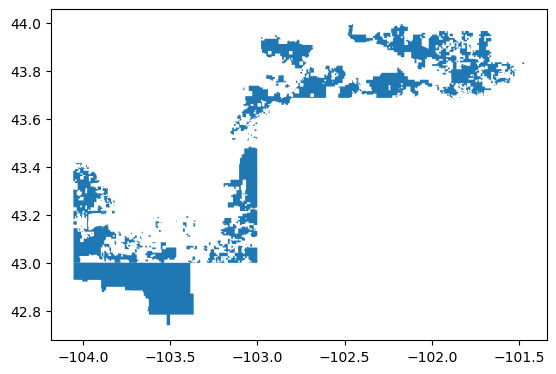

In [208]:
%store -r buffalo_gdf
buffalo_gdf.plot()

In [209]:
buffalo_gdf.total_bounds

array([-104.05473027,   42.74093601, -101.47233564,   43.99459902])

In [298]:
%run habitat.py

Download in list and merge as before with `merge_soil()`.

In [228]:
%store -r buffalo_da
try:
    buffalo_da
except NameError:
    buffalo_urls = soil_url_dict(buffalo_gdf)
    buffalo_da = merge_soil(buffalo_urls)
    bounds = buffalo_gdf.to_crs(buffalo_da.rio.crs).total_bounds
    bounds = bounds + [-0.1, -0.1, 0.1, 0.1] # add buffer
    buffalo_da = buffalo_da.rio.clip_box(*bounds)
    %store buffalo_da
    print("buffalo_da created and stored")
else:
    print("buffalo_da already exists")

buffalo_da already exists


In [216]:
#buffalo_da.rio.write_crs("EPSG:4326").plot(robust=True)

In [214]:
from landmapy.index import redline_over_index

Changes desired for plot below:

- Different colors by grassland.
- crop to bounding box (with extra).

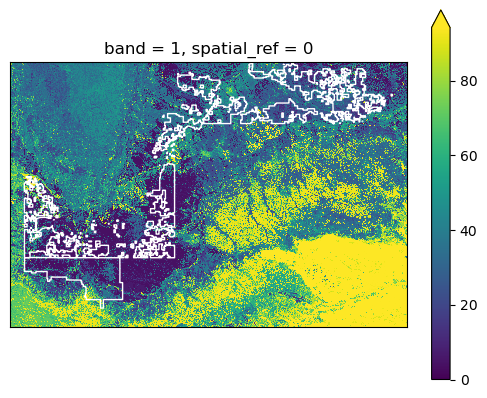

In [219]:
redline_over_index(buffalo_gdf, buffalo_da, edgecolor="white")

## Get MACA and SRTM data

- At least one **climate** variable from the [MACAv2 THREDDS data server](http://thredds.northwestknowledge.net:8080/thredds/reacch_climate_CMIP5_macav2_catalog2.html).
- See [EDA Lesson 3. How to Download MACA2 Climate Data Using Python](https://www.earthdatascience.org/courses/use-data-open-source-python/hierarchical-data-formats-hdf/get-maca-2-climate-data-netcdf-python/).
- [CONUS Page](http://thredds.northwestknowledge.net:8080/thredds/catalog/MACAV2/BNU-ESM/catalog.html?dataset=REACCHDatasetScan_BNU-ESM_MACAV2/macav2metdata_pr_BNU-ESM_r1i1p1_rcp85_2026_2030_CONUS_monthly.nc)
- [OPENDAP](http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/BNU-ESM/macav2metdata_pr_BNU-ESM_r1i1p1_rcp85_2026_2030_CONUS_monthly.nc)
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/BNU-ESM/macav2metdata_pr_BNU-ESM_r1i1p1_rcp85_2026_2030_CONUS_monthly.nc.html
- Scenarios:
Consider climate variables air termperature or precipitation (`_pr_`) with OPENDAP
    - monthly data
    - 5-year interval (2026-30) 
    - RCP45 (current) vs RCP85 (high)
- 

In [303]:
maca_df = process_maca({'buffalo': buffalo_gdf})

Note:Caching=1
Note:Caching=1


In [304]:
maca_df[['site_name', 'scenario', 'climate', 'year']]

,site_name,scenario,climate,year
0,buffalo,pr,rcp85,2026
1,buffalo,pr,rcp45,2026


### Plot MACA

Now what I want to do is be able to plot each of the MACA images.
Borrowing heavily from
[Hannah Rieder Step 3](https://github.com/hanried/habitat-suitability/blob/main/03-habitat-suitability-climate.ipynb).

In [305]:
maca_da = maca_df.loc[0,'da']
type(maca_da)

xarray.core.dataarray.DataArray

In [306]:
maca_da.rio.crs

CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')

In [307]:

bounds = buffalo_gdf.to_crs(maca_da.rio.crs).total_bounds
bounds = bounds + [-0.1, -0.1, 0.1, 0.1] # add buffer
maca_da = maca_da.rio.clip_box(*bounds)


In [309]:
#maca_da.plot(col="time",col_wrap=5)

In [311]:
# Find the average precipitation for each pixel across all months for each individual year?
maca_yearly_da= maca_da.groupby('time.year').mean()
maca_yearly_da['year' == 2027]

<xarray.DataArray 'precipitation' (lat: 31, lon: 63)> Size: 8kB
array([[50.1179  , 52.859303, 53.22749 , ..., 51.885975, 51.52255 ,
        52.05939 ],
       [50.70669 , 51.905315, 49.57488 , ..., 50.594223, 50.94772 ,
        51.308704],
       [50.68571 , 49.111057, 45.38306 , ..., 50.515514, 50.759876,
        51.540188],
       ...,
       [57.07065 , 63.66563 , 64.912544, ..., 46.474636, 46.240856,
        46.305683],
       [59.20239 , 66.58268 , 67.42183 , ..., 45.869442, 46.158817,
        46.197235],
       [60.90355 , 68.42959 , 68.24732 , ..., 45.190624, 45.512196,
        45.390503]], dtype=float32)
Coordinates:
  * lon      (lon) float64 504B -104.1 -104.0 -104.0 ... -101.6 -101.5 -101.5
  * lat      (lat) float64 248B 42.73 42.77 42.81 42.85 ... 43.9 43.94 43.98
    crs      int64 8B 0
    year     int64 8B 2026
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

In [312]:
# Calculate the total annual precipitation for each year?
maca_annual = maca_yearly_da.groupby('year').sum(["lat", "lon"])
maca_annual

<xarray.DataArray 'precipitation' (year: 5)> Size: 20B
array([ 97872.03 ,  86800.75 ,  94284.734, 102012.36 ,  85493.21 ],
      dtype=float32)
Coordinates:
    crs      int64 8B 0
  * year     (year) int64 40B 2026 2027 2028 2029 2030
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

Want to plot over time ...

Not working yet

In [314]:
maca_2027 = maca_yearly_da['year' == 2027]
type(maca_2027)

xarray.core.dataarray.DataArray

In [319]:
#maca_2027.plot()

In [317]:
maca_2027 = maca_2027.rio.write_crs("EPSG:4326")

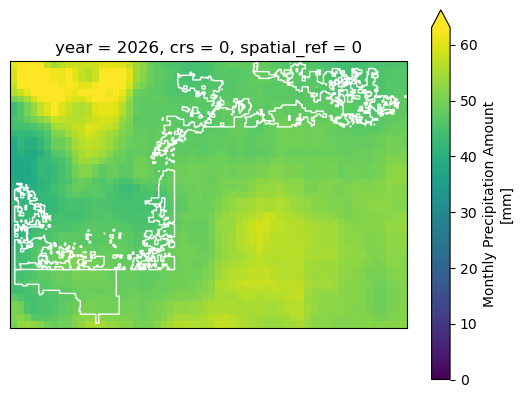

In [318]:
redline_over_index(buffalo_gdf, maca_2027, edgecolor="white")

In [189]:
type(xr.DataArray(maca_df[['da']].iloc[0].values))

xarray.core.dataarray.DataArray

In [273]:
type(buffalo_da)

xarray.core.dataarray.DataArray

In [194]:
buffy_da = xr.DataArray(maca_df[['da']].iloc[0].values)
buffy_da = buffy_da.rio.write_crs("EPSG:4326")
type(buffy_da)

xarray.core.dataarray.DataArray

In [195]:
redline_over_index(buffalo_gdf, buffy_da, edgecolor="white")

MissingSpatialDimensionError: x dimension not found. 'rio.set_spatial_dims()' or using 'rename()' to change the dimension name to 'x' can address this.

### Extra Stuff

Below are ideas not implemented.

In [20]:
climate_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data',
    'habitat',
    'climate_data'
)
climate_dir

'/Users/brianyandell/earth-analytics/data/habitat/climate_data'

In [ ]:
Rcp85 worse
RCP45 usual
monthly

In [21]:
%run maca.py

help(download_macav2_data)

Help on function download_macav2_data in module __main__:

download_macav2_data(variable, scenarios, years, output_dir='climate_data')
    Download climate data from the MACAv2 THREDDS data server for specified scenarios and time periods.    
    
    Parameters
    ----------
        variable (str): The climate variable to download (e.g., 'pr' for precipitation, 'tasmax' for maximum temperature).
        scenarios (list): A list of two scenario names (e.g., ['historical', 'rcp85']).
        years (list): A list of two time periods (start and end year) for each scenario (e.g., [1950, 2005] for 'historical').
        output_dir (str): Directory to save the downloaded NetCDF files.    
    Returns
    -------
        downloaded_files (list): A list of file paths to the downloaded NetCDF files.



In [ ]:
download_macav2_data(variable, scenarios, years, output_dir=climate_dir)
http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/BNU-ESM/macav2metdata_pr_BNU-ESM_r1i1p1_rcp85_2026_2030_CONUS_monthly.nc

In [ ]:
# %run srtm.py

## Harmonize Data

Make sure to reproject so all grids line up.